# COMPUTATIONAL TOOLS FOR DATA SCIENCE

## 1. DATA PROCESSING AND VISUALIZATION

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px # for interactive plots
from wordcloud import WordCloud # for wordclouds
import re  # for regular expressions

from collections import defaultdict

import nltk
from nltk.corpus import stopwords
from sklearn.utils import murmurhash3_32
import networkx as nx
from itertools import combinations
from community import community_louvain  # For Louvain method
import random
random.seed(42)

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
file1 = '/Users/matteopiccagnoni/Desktop/DTU/Computational tools for data science/project/computationaltoolsDS/computationaltoolsDS/medicine_details.csv'
data = pd.read_csv(file1)

# Print the dataframes to verify
print("data from medicine_details.csv:")
print(data.head())  

data from medicine_details.csv:
              Medicine Name  \
0   Avastin 400mg Injection   
1  Augmentin 625 Duo Tablet   
2       Azithral 500 Tablet   
3          Ascoril LS Syrup   
4         Aciloc 150 Tablet   

                                         Composition  \
0                                Bevacizumab (400mg)   
1    Amoxycillin  (500mg) +  Clavulanic Acid (125mg)   
2                               Azithromycin (500mg)   
3  Ambroxol (30mg/5ml) + Levosalbutamol (1mg/5ml)...   
4                                 Ranitidine (150mg)   

                                                Uses  \
0  Cancer of colon and rectum Non-small cell lung...   
1                  Treatment of Bacterial infections   
2                  Treatment of Bacterial infections   
3                      Treatment of Cough with mucus   
4  Treatment of Gastroesophageal reflux disease (...   

                                        Side_effects  \
0  Rectal bleeding Taste change Headache Noseblee..

### 1.1 VISUALIZATIONS

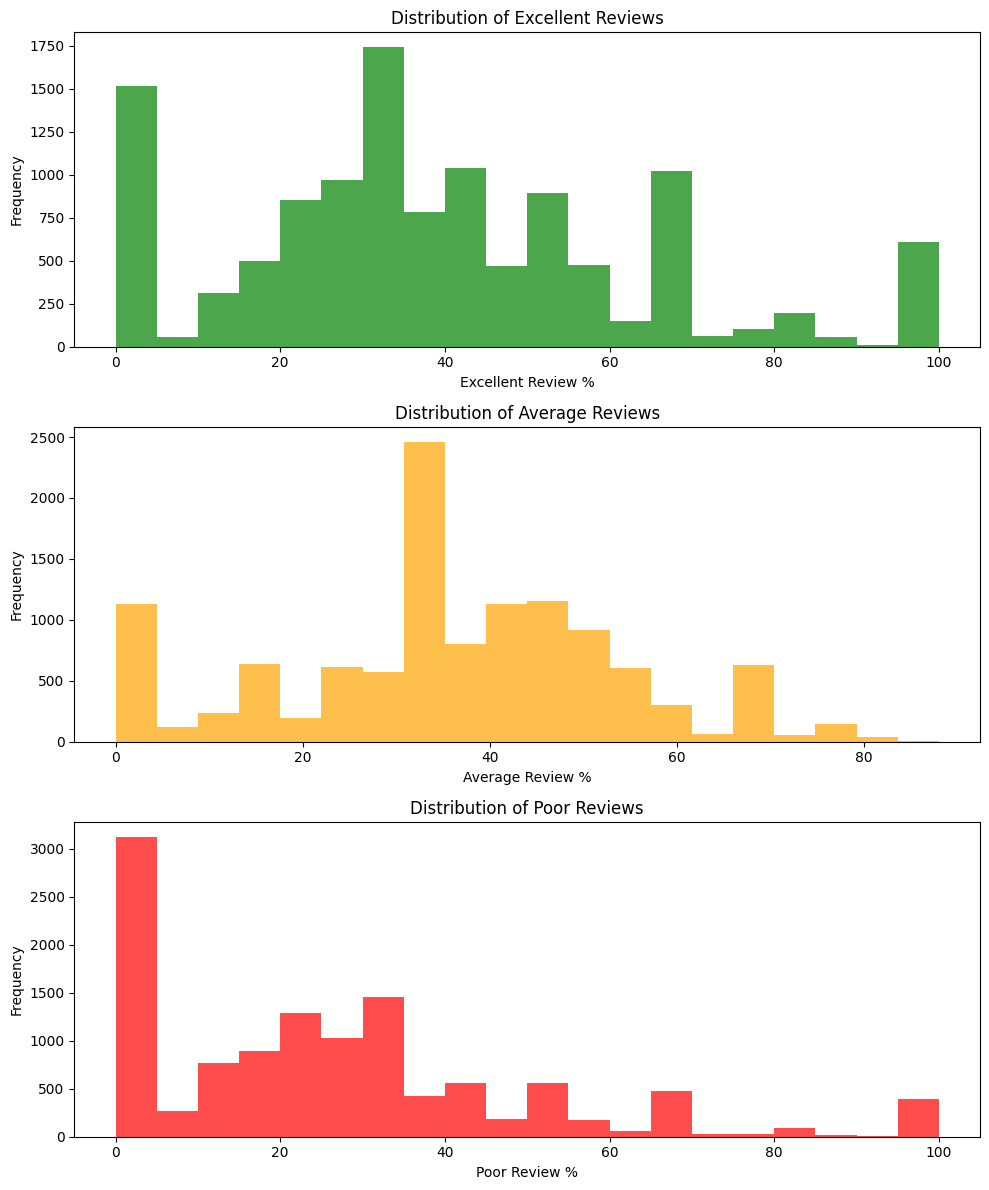

In [3]:
# three plot to see the distribution of the different percentages of reviews
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

ax1.hist(data['Excellent Review %'], bins=20, color='green', alpha=0.7)
ax1.set_title('Distribution of Excellent Reviews')
ax1.set_xlabel('Excellent Review %')
ax1.set_ylabel('Frequency')

ax2.hist(data['Average Review %'], bins=20, color='orange', alpha=0.7)
ax2.set_title('Distribution of Average Reviews')
ax2.set_xlabel('Average Review %')
ax2.set_ylabel('Frequency')

ax3.hist(data['Poor Review %'], bins=20, color='red', alpha=0.7)
ax3.set_title('Distribution of Poor Reviews')
ax3.set_xlabel('Poor Review %')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [4]:
# Define weights for each rating category. Here we're assuming:
#   Good ratings contribute positively to the score (scaled up)
#   Middle ratings contribute a neutral or mid-range value
#   Bad ratings contribute negatively to the score (scaled down)

good_weight = 10  # Max score for good ratings
middle_weight = 5 # Midpoint score for middle ratings
bad_weight = 0    # Min score for bad ratings

# Calculate the weighted score for each observation
data['Ratings'] = (
    data['Excellent Review %'] * good_weight +
    data['Average Review %'] * middle_weight +
    data['Poor Review %'] * bad_weight
) / 100  # Divide by 100 to bring it back to a 0-10 scale

# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', 1000)  
# print(data[['Ratings']])
print(data[['Ratings']].head())

   Ratings
0     5.00
1     6.45
2     5.90
3     4.45
4     5.25


In [5]:
# counting the number of manufacturers
print(data['Manufacturer'].value_counts())

Manufacturer
Sun Pharmaceutical Industries Ltd    820
Intas Pharmaceuticals Ltd            654
Cipla Ltd                            574
Torrent Pharmaceuticals Ltd          445
Lupin Ltd                            435
                                    ... 
Hicare Pharma                          1
Nexeum Pharmaceuticals                 1
Bio Swizz Pharmaceuticals              1
Nutratec Pharmaceuticals               1
Grevis Pharmaceuticals Pvt Ltd         1
Name: count, Length: 759, dtype: int64


In [6]:
# calculating the average rating for each manufacturer
manufacturer_ratings = data.groupby('Manufacturer')['Ratings'].mean().sort_values(ascending=False)
print(manufacturer_ratings)

Manufacturer
Medlius Pharma Pvt. Limited    10.0
Matias Healthcare Pvt Ltd      10.0
Ampra Pharmaceuticals          10.0
Matteo Healthcare Pvt Ltd      10.0
Lynderma Pharmaceuticals       10.0
                               ... 
Nicholas Healthcare Limited     0.0
Astra Labs                      0.0
Baxton Pharmacia                0.0
Arlak Biotech Pvt Ltd           0.0
Aarti Life Science              0.0
Name: Ratings, Length: 759, dtype: float64


In [7]:
# interactive plot to visualize the average ratings by manufacturer
# you can zoom in and out, hover over the bars to see the values
fig = px.bar(
    x=manufacturer_ratings.index,
    y=manufacturer_ratings.values,
    title='Average Ratings by Manufacturer',
    labels={'x': 'Manufacturer', 'y': 'Average Rating'}
)

fig.update_layout(
    height=600,
    width=2000, # number of manufacturers
    xaxis_tickangle=45,
    showlegend=False
)

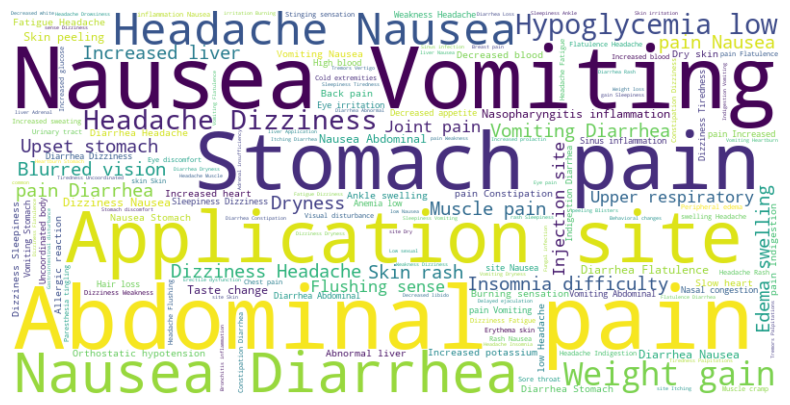

In [8]:
# Step 1: Split side effects based on capital letters and clean up the list
data['Side_effects'] = data['Side_effects'].apply(lambda x: re.findall(r'[A-Z][a-z]*\s?[a-z]*', x))

# Step 2: Combine all side effects into a single string for word cloud
all_side_effects = ' '.join([' '.join(effect) for effect in data['Side_effects']])

# Step 3: Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_side_effects)

# Step 4: Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 1.2 DATA PROCESSING

In [9]:
# MARCO'S CODE TO CREATE A NEW COLUMN WITH THE NUMBER OF COMPONENTS
'''# Print the dataframe to verify the new feature
# print("data with ratings:")
# print(data)

# Step 1: Split the Composition column by " + " to get a list of components for each observation
data['Composition'] = data['Composition'].str.split('+')

# Step 2: Apply One-Hot Encoding
# This creates a dataFrame where each unique component is a column with 1 or 0 indicating presence in each row
one_hot_data = data['Composition'].str.join('|').str.get_dummies()

# Step 3: Concatenate the one-hot encoded columns back with the original dataFrame (if needed)
data2 = pd.concat([one_hot_data], axis=1)

# Display the resulting dataFrame
# print(data2.columns)
#following 2 lines printed the one hot ingredients for the second medicine to see if the one hot encoding of the strings it's correct
# second_row_dict = data2.iloc[1].to_dict()
# print(second_row_dict)
# print(data2.head())'''

'# Print the dataframe to verify the new feature\n# print("data with ratings:")\n# print(data)\n\n# Step 1: Split the Composition column by " + " to get a list of components for each observation\ndata[\'Composition\'] = data[\'Composition\'].str.split(\'+\')\n\n# Step 2: Apply One-Hot Encoding\n# This creates a dataFrame where each unique component is a column with 1 or 0 indicating presence in each row\none_hot_data = data[\'Composition\'].str.join(\'|\').str.get_dummies()\n\n# Step 3: Concatenate the one-hot encoded columns back with the original dataFrame (if needed)\ndata2 = pd.concat([one_hot_data], axis=1)\n\n# Display the resulting dataFrame\n# print(data2.columns)\n#following 2 lines printed the one hot ingredients for the second medicine to see if the one hot encoding of the strings it\'s correct\n# second_row_dict = data2.iloc[1].to_dict()\n# print(second_row_dict)\n# print(data2.head())'

In [10]:
# MATTEO'S CODE THAT USES MARCO'S BUT CLEANED THE COLUMNS NAMES
# Step 1: Split the Composition column by " + " to get a list of components for each observation
data['Composition'] = data['Composition'].str.split('+')

# Step 2: Apply One-Hot Encoding
one_hot_data = data['Composition'].str.join('|').str.get_dummies()
one_hot_data.columns = one_hot_data.columns.str.strip().str.lower().str.replace(' ', '_') # clean the name of the columns

# Step 3: Concatenate the one-hot encoded columns with the original data (including Medicine_Name)
data_final = pd.concat([data[['Medicine Name']], one_hot_data], axis=1)
data_final.columns = data_final.columns.str.strip().str.lower().str.replace(' ', '_') # clean the name of the columns

In [11]:
# Display the resulting dataframe to verify the new features
print("Data with One-Hot Encoded Composition:")
print(data_final.head())

Data with One-Hot Encoded Composition:
              medicine_name  human_insulin/soluble_insulin_(25%)  \
0   Avastin 400mg Injection                                    0   
1  Augmentin 625 Duo Tablet                                    0   
2       Azithral 500 Tablet                                    0   
3          Ascoril LS Syrup                                    0   
4         Aciloc 150 Tablet                                    0   

   human_insulin/soluble_insulin_(30%)  human_insulin/soluble_insulin_(50%)  \
0                                    0                                    0   
1                                    0                                    0   
2                                    0                                    0   
3                                    0                                    0   
4                                    0                                    0   

   acetylcysteine_(100mg)  albendazole_(200mg)  albendazole_(400mg)  \
0     

## 2. ADRIAN ( I STILL NEED A COOL HEADER)

### 2.1 Sparse Matrix Representation and Analysis

This section focuses on converting the medicine composition data into a sparse matrix format for efficient storage and processing. 
The steps include:
- Mapping Components: Assigning unique indices to components for a more compact representation.
- Sparse Matrix Conversion: Replacing component names with indices in the DataFrame.
- Sparsity Analysis: Calculating the percentage of zero and non-zero elements to understand the data distribution.
- Tuple-Based Representation: Extracting non-zero elements into tuples for efficient storage and further processing.
- Reverse Mapping: Mapping indices back to original component names for interpretation.


In [ ]:
# Map function to parse compositions and emit intermediate results
def map_composition(row):
    medicine_name = row["Medicine Name"]
    composition = row["Composition"]
    
    components = []
    for component in composition.split("+"):
        component = component.strip()
        name, quantity = component.rsplit("(", 1)
        name = name.strip()
        quantity = quantity.strip(")")
        components.append((medicine_name, name, quantity))
    return components

# Reduce function to aggregate results into a final structure
def reduce_components(mapped_data):
    # Collect all unique components
    unique_components = set()
    for entry in mapped_data:
        _, component_name, _ = entry
        unique_components.add(component_name)
    
    # Initialize the result structure
    result = defaultdict(lambda: {component: "" for component in unique_components})
    
    # Populate the structure with quantities
    for medicine_name, component_name, quantity in mapped_data:
        result[medicine_name][component_name] = quantity
    
    return result

Read the dataset and process medicine compositions to create a structured mapping.

Reduce mapped data by consolidating redundant or duplicate components.

In [ ]:
# Read the first two columns of the data
df = pd.read_csv('./medicine_details.csv', usecols=[0,1])
df.head()

# Apply the map function to all rows
mapped_data = []
for _, row in df.iterrows():
    mapped_data.extend(map_composition(row))

# Apply the reduce function
reduced_data = reduce_components(mapped_data)

# Convert the reduced data to a DataFrame
final_df = pd.DataFrame.from_dict(reduced_data, orient="index").reset_index()
final_df.rename(columns={"index": "Medicine Name"}, inplace=True)

# Display the final DataFrame
final_df

Assign unique integer indices to each component in the dataset and replace component names in the DataFrame with their respective integer indices.

Replace component names in the DataFrame with their respective integer indices.

In [ ]:
# Get unique values from the DataFrame (excluding "")
unique_values = sorted(set(final_df.values.flatten()) - {""})
value_mapping = {v: i for i, v in enumerate(unique_values)}  # Map each unique value to an index
# Display first 5 unique values and their corresponding indices
print("\nValue Mapping:")
for value, index in list(value_mapping.items())[:5]:
    print(f"{value} -> {index}")

# Replace DataFrame values with indices
sparse_matrix = final_df.set_index("Medicine Name").map(lambda x: value_mapping.get(x, -1)) # TODO If only presence is required (probably for market item), replace the get function with a lambda function that returns 1 if x is not -1 else 0
sparse_matrix.head(5)

Analyze sparsity and non-zero elements in the sparse matrix.

In [ ]:
# Calculate statistics
total_elements = sparse_matrix.size
total_zeros = (sparse_matrix == -1).sum().sum()
total_non_zeros = total_elements - total_zeros
percentage_zeros = (total_zeros / total_elements) * 100

print("Sparse Matrix Statistics:")
print(f"Total elements: {total_elements}")
print(f"Number of zeros: {total_zeros}")
print(f"Number of non-zeros: {total_non_zeros}")
print(f"Percentage of zeros: {percentage_zeros:.2f}%")

 Extract non-zero elements as tuples for efficient storage and processing.

In [ ]:
# Step 2: Convert to tuple-based representation
# Create row and column arrays
row_array = sparse_matrix.index.tolist()
column_array = sparse_matrix.columns.tolist()

# Create a list of tuples (row_index, column_index, value) for non-zero values
non_zero_tuples = [
    (row_idx, col_idx, sparse_matrix.iloc[row_idx, col_idx])
    for row_idx in range(sparse_matrix.shape[0])
    for col_idx in range(sparse_matrix.shape[1])
    if sparse_matrix.iloc[row_idx, col_idx] != -1
]



Reverse map indices to their original component names for readability.

In [ ]:
# This dictionary maps each unique value to its index
reverse_mapping = {i: v for v, i in value_mapping.items()}  # Reverse the dictionary to get values from indices

# Print some tuples along with their components
print("Sample tuples with indexed values and their components:")
for i, (row_idx, col_idx, value_index) in enumerate(non_zero_tuples[:5]):  # Limit to first 5 tuples
    original_value = reverse_mapping.get(value_index, "Unknown")  # Get the original value using the reverse mapping
    print(f"Tuple {i+1}: (Row: {row_idx}, Column: {col_idx}, Indexed Value: {value_index}, Original Component: {original_value})")

These transformations allow for scalable processing of large datasets and facilitate operations such as similarity computation or recommendation systems based on medicine composition.

### 2.2 Market-Basket Analysis

## 3. Community Detection
Identify and group similar documents into communities based on their content using advanced techniques like Minhashing and Locality Sensitive Hashing (LSH). The dteps are: 
- Data Preprocessing: The dataset is cleaned by removing stopwords and unnecessary terms from the Uses column to ensure meaningful comparisons.
- Shingle Generation: Documents are split into overlapping sequences of words (k-shingles) to represent their content.
- Minhashing: A signature matrix is created for each document to approximate the Jaccard similarity between documents efficiently.
- Locality Sensitive Hashing (LSH): Documents are grouped into buckets based on their Minhash signatures to find potential candidate pairs for similarity analysis.
- Graph Construction: A graph is built with documents as nodes and edges representing potential similarities above a threshold (e.g., Jaccard similarity > 0.8).
- Community Detection: The Louvain method is applied to detect communities within the graph, grouping documents based on shared content.

Load the dataset and clean the text data by removing stopwords and specific terms.

In [ ]:
# Download NLTK stopwords
nltk.download('stopwords')

# Load data
file_path = 'medicine_details.csv'
data = pd.read_csv(file_path)

# Text preprocessing: remove stopwords and specific terms
stop_words = set(stopwords.words('english'))
stop_words.add('treatment')

Create k-shingles (subsequences of words) from the cleaned text to facilitate similarity computation.

In [ ]:
# Remove stopwords and parentheses without removing their content
def clean_text(text):
    """
    Remove stopwords and parentheses '(' and ')', but keep the content inside parentheses.
    """
    # Remove parentheses while keeping their content
    text = re.sub(r'[()]', '', text)
    # Remove stopwords
    words = [word for word in text.split() if word.lower() not in stop_words]
    return ' '.join(words)

# Apply to the 'Uses' column
data['Uses'] = data['Uses'].apply(lambda x: clean_text(str(x)))


# Function to generate shingles
def create_shingles(text, k=3):
    """
    Split text into k-shingles (n-grams of size k).
    """
    words = text.split()
    if len(words) < k:
        return set(words)
    return set([' '.join(words[i:i+k]) for i in range(len(words) - k + 1)])


Create a mapping from shingles to indices for use in the Minhashing process.

In [ ]:
# Generate shingles for each document
k = 3  # Size of shingles
data['Shingles'] = data['Uses'].apply(lambda x: create_shingles(str(x)))

# Create the universe of shingles and map them to indices
all_shingles = set().union(*data['Shingles'])
shingle_to_idx = {shingle: idx for idx, shingle in enumerate(all_shingles)}


Generate Minhash signatures for each document to approximate the Jaccard similarity between sets of shingles.

In [ ]:
# Minhashing
n_hashes = 100  # Number of hash functions
hash_functions = [lambda x, seed=seed: murmurhash3_32(x, seed=seed) for seed in range(n_hashes)]

def minhash_signature(shingles, n_hashes, shingle_to_idx):
    """
    Generate a Minhash signature for a set of shingles.
    """
    signature = np.full(n_hashes, np.inf)
    for shingle in shingles:
        shingle_idx = shingle_to_idx[shingle]
        for i, h in enumerate(hash_functions):
            signature[i] = min(signature[i], h(str(shingle_idx)))
    return signature

data['Minhash'] = data['Shingles'].apply(lambda x: minhash_signature(x, n_hashes, shingle_to_idx))


Group similar documents using LSH to identify potential candidate pairs for similarity analysis.

In [ ]:
# Locality Sensitive Hashing (LSH)
def lsh(signatures, bands, rows):
    """
    Perform Locality Sensitive Hashing (LSH) to group similar documents.
    """
    buckets = {}
    for doc_id, signature in enumerate(signatures):
        for band in range(bands):
            band_signature = tuple(signature[band*rows:(band+1)*rows])
            if band_signature not in buckets:
                buckets[band_signature] = []
            buckets[band_signature].append(doc_id)
    return buckets

bands = 20  # Number of bands
rows = n_hashes // bands  # Rows per band
lsh_buckets = lsh(data['Minhash'], bands, rows)

Identify potential similar document pairs based on LSH buckets.

In [ ]:
# Find potential similar document pairs
similar_pairs = set()
for bucket_docs in lsh_buckets.values():
    if len(bucket_docs) > 1:
        similar_pairs.update(combinations(bucket_docs, 2))

Construct a graph of documents and add edges based on the Jaccard similarity between shingles.

In [ ]:
# Build a graph of similar documents
G = nx.Graph()
G.add_nodes_from(range(len(data)))  # Add nodes for each document

# Add edges based on similar pairs
for doc1, doc2 in similar_pairs:
    shingles1 = data.loc[doc1, 'Shingles']
    shingles2 = data.loc[doc2, 'Shingles']
    # Compute Jaccard similarity
    jaccard_sim = len(shingles1 & shingles2) / len(shingles1 | shingles2)
    if jaccard_sim > 0.8:  # Similarity threshold
        G.add_edge(doc1, doc2, weight=jaccard_sim)


Apply the Louvain method to detect communities in the graph based on edge weights.

In [ ]:
# Apply Louvain community detection
partition = community_louvain.best_partition(G, weight='weight')

# Add community labels to the graph as node attributes
nx.set_node_attributes(G, partition, 'community')

# Save the graph with communities
nx.write_gexf(G, 'graph_with_communities.gexf')

# Add community labels to the dataframe
data['Community'] = data.index.map(partition)

# Save the data with community information
data.to_csv('data_with_communities.csv', index=False)

Print the statistics of the graph and the detected communities

In [ ]:
# Print summary
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())
print('Number of communities:', len(set(partition.values())))
print('Modularity:', community_louvain.modularity(partition, G))

## 4. TF-IDF 
The purpose of this section is to analyze communities identified in the dataset and visualize their content using TF-IDF scores and word clouds. This helps in understanding the most significant terms within each community for different columns ('Uses', 'Composition', and 'Side Effects'). The visualization aids in uncovering patterns and insights about the documents grouped into communities.
The steps are:
- Identify Top Communities: Extract the indices of the top communities for analysis.
- Calculate TF-IDF Scores: Define a function to compute TF-IDF scores for words in the documents of each community.
- Select Top Words by TF-IDF: Create a function to select the most significant words from the TF-IDF scores.
- Map Community Names: Assign names to communities based on the top words from the TF-IDF analysis.
- Rename Communities in the DataFrame: Add the community names to the DataFrame as a new column.
- Generate Word Clouds for 'Uses' Column: Create and plot word clouds to visualize the most important words for each community in the 'Uses' column.
- Repeat for 'Composition' and 'Side Effects' Columns: Generate and plot word clouds for the 'Composition' and 'Side Effects' columns to gain further insight into the communities.

In [ ]:
# Function to calculate TF-IDF for a community
def calculate_tfidf(texts):
    vectorizer = TfidfVectorizer()
    if not texts:  # Check if texts are empty
        return {}
    tfidf_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    return dict(zip(feature_names, scores))

# Function to get top N words by TF-IDF
def get_top_tfidf_words(tfidf_scores, n=2):
    if not tfidf_scores:  # Handle empty TF-IDF scores
        return ["unknown"] * n
    sorted_words = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    return [word for word, score in sorted_words[:n]]

In [ ]:
# Read the dataset with community labels
data = pd.read_csv('data_with_communities.csv')

# Get the top 10 communities by document count
top_communities = data['Community'].index

Map Communities to Names Based on TF-IDF and rename Communities in the DataFrame

In [ ]:
# Create a mapping for community names
community_names = {}

# Calculate TF-IDF for the top communities and rename them
for community in top_communities:
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Uses'].dropna().tolist()
    
    # Skip empty texts
    if not community_texts:
        community_names[community] = "unknown"
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    # Get top 2 words by TF-IDF
    top_words = get_top_tfidf_words(tfidf_scores, n=2)
    
    # Rename community with the top 2 words
    community_names[community] = ' '.join(top_words)

# Rename the communities in the DataFrame
data['Community Name'] = data['Community'].map(community_names)

# Save the updated dataset with renamed communities
data.to_csv('data_with_communities.csv', index=False)


Generate Word Clouds for Each Community's 'Uses' Column

In [ ]:
# Set up the 2x5 grid for subplots
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

# Generate word clouds and plot for each community
for i, community in enumerate(top_communities):
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Uses'].dropna().tolist()
    
    # Skip empty communities
    if not community_texts:
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    if not tfidf_scores:
        continue  # Skip if no TF-IDF scores are available

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    
    # Plot on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{community_names.get(community, "Community " + str(community))}', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('community_wordclouds.png', dpi=300)
plt.show()

Generate Word Clouds for Each Community's 'Composition' Column

In [ ]:
# Clean the Composition column
def clean_text(text):
    """
    Remove all occurrences of parentheses (and their contents) and '+' symbols from the text.
    """
    text = re.sub(r'\(.*?\)', '', text)  # Remove parentheses and their content
    text = text.replace('+', '')  # Remove '+' symbols
    return text.strip()

data['Composition'] = data['Composition'].apply(lambda x: clean_text(str(x)))

# Set up the 2x5 grid for subplots
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

# Generate word clouds and plot for each community
for i, community in enumerate(top_communities):
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Composition'].dropna().tolist()
    
    # Skip empty communities
    if not community_texts:
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    if not tfidf_scores:
        continue  # Skip if no TF-IDF scores are available

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    
    # Plot on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{community_names.get(community, "Community " + str(community))}', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('community_wordclouds.png', dpi=300)
plt.show()

Generate Word Clouds for Each Community's 'Side Effects' Column

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(18, 10))
axes = axes.flatten()

for i, community in enumerate(top_communities):
    # Filter texts for the current community
    community_texts = data[data['Community'] == community]['Side_effects'].dropna().tolist()
    
    # Skip empty communities
    if not community_texts:
        continue
    
    # Calculate TF-IDF scores
    tfidf_scores = calculate_tfidf(community_texts)
    
    if not tfidf_scores:
        continue  # Skip if no TF-IDF scores are available

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tfidf_scores)
    
    # Plot on the respective subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'{community_names.get(community, "Community " + str(community))}', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig('community_wordclouds.png', dpi=300)
plt.show()